In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder  
from sklearn.ensemble import RandomForestRegressor
import time
import datetime
from dateutil import parser
import collections

In [3]:
#x = np.random.rand(10000,2)
x=pd.read_csv('results.csv', sep=',',header=None)
x = x.values

In [4]:
dx0 = 0.001
dx1 = 0.001

In [5]:
def minmax_scaling(array, columns, min_val=0, max_val=1):
    ary_new = array.astype(float)
    if len(ary_new.shape) == 1:
        ary_new = ary_new[:, np.newaxis]

    if isinstance(ary_new, pd.DataFrame):
        ary_newt = ary_new.loc
    elif isinstance(ary_new, np.ndarray):
        ary_newt = ary_new
    else:
        raise AttributeError('Input array must be a pandas'
                             'DataFrame or NumPy array')

    numerator = ary_newt[:, columns] - ary_newt[:, columns].min(axis=0)
    denominator = (ary_newt[:, columns].max(axis=0) -
                   ary_newt[:, columns].min(axis=0))
    ary_newt[:, columns] = numerator / denominator

    if not min_val == 0 and not max_val == 1:
        ary_newt[:, columns] = (ary_newt[:, columns] *
                                (max_val - min_val) + min_val)

    return ary_newt[:, columns]

In [6]:
y = minmax_scaling(x, columns=[0, 1])

In [7]:
i = np.floor(y[:,0]/dx0).astype('i')
j = np.floor(y[:,1]/dx1).astype('i')
gx = np.arange(0.5*dx0,1,dx0)
gy = np.arange(0.5*dx1,1,dx1)

In [8]:
from collections import defaultdict
counts = np.zeros((len(gx),len(gy)))
for n in range(len(i)):
    try:
        counts[i[n]-1][j[n]-1] += 1
    except:
        print(n)

<function matplotlib.pyplot.colorbar>

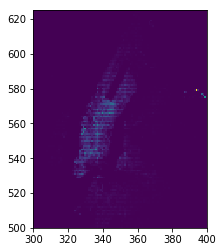

In [95]:
plt.imshow(counts)
plt.xlim(300,400)
plt.ylim(500,625)
plt.colorbar

In [9]:
latlongmap = {}
for num in range(len(x)):
    latlongmap[(x[num][0], x[num][1])] = (i[num],j[num])

In [10]:
class Pair:
    def __init__(self, lat, long):
        self.lat = lat
        self.long = long

    def __hash__(self):
        return hash((self.lat, self.long))

    def __eq__(self, other):
        return (self.lat, self.long) == (other.lat, other.long)

In [11]:
latlongmap = {}
for num in range(len(x)):
    latlongmap[Pair(x[num][0],x[num][1])] = Pair(i[num],j[num])

In [12]:
import math
def truncate(number, digits) -> float:
    stepper = pow(10.0, digits)
    return math.trunc(stepper * number) / stepper

In [124]:
def create_parsed(file1, file2):
    fil = pd.read_csv(file1, sep = ',', header=None)
    fil = fil.values
    fil = fil[1:]
    wfil = open(file2, 'w')
    for i in range(len(fil)):
   
        x = truncate(float(fil[i][1]),3)
        y = truncate(float(fil[i][2]),3)
        if(Pair(x,y) in latlongmap):
            grid =  latlongmap[Pair(x,y)]
            try:
                row = fil[i]
                times = row[0][:-5]+'00:00'
                #print(times)
                d = parser.parse(times)
                timestamp = int(time.mktime(d.timetuple()))
                format(grid.lat)
                format(grid.long)
                wfil.write(str(timestamp)+','+ format(grid.lat) +','+ format(grid.long))
                wfil.write('\n')
            except:
                pass
    wfil.close()

    
create_parsed('uber-raw-data-apr14.csv', 'april_parsed.csv')
create_parsed('uber-raw-data-may14.csv', 'may_parsed.csv')
create_parsed('uber-raw-data-jun14.csv', 'june_parsed.csv')
create_parsed('uber-raw-data-jul14.csv', 'july_parsed.csv')
create_parsed('uber-raw-data-aug14.csv', 'august_parsed.csv')
create_parsed('uber-raw-data-sep14.csv', 'september_parsed.csv')

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2827: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [13]:
aprilfile = pd.read_csv('april_parsed.csv', sep=',',header=None)
mayfile = pd.read_csv('may_parsed.csv', sep=',',header=None)
junefile = pd.read_csv('june_parsed.csv', sep=',',header=None)
julyfile = pd.read_csv('july_parsed.csv', sep=',',header=None)
augustfile = pd.read_csv('august_parsed.csv', sep=',',header=None)
septemberfile = pd.read_csv('september_parsed.csv', sep=',',header=None)

In [14]:
y = aprilfile.append(mayfile).append(junefile).append(julyfile).append(augustfile)
y = y.values
len(y)

2547466

In [15]:
#conaitns a hashMap of (lat,lon,epoch time) as key and number of rides as value
bin_map = {}
for i in range(len(y)):
    t = (y[i][1],y[i][2],y[i][0])
    if(t in bin_map):
        count = bin_map[t]
        bin_map[t] = count + 1;
    else:
        bin_map[t] = 1;

In [16]:
train_points = []
train_labels = []

for key, value in bin_map.items():
    train_points.append(key)
    train_labels.append(value)

aX = np.asarray(train_points) 
ay = np.asarray(train_labels)

Regressor = RandomForestRegressor(min_samples_split=1)
Regressor.fit(aX, ay)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=1, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [17]:
#read the parsed may file 
test_values  = septemberfile.values
test_map = {}
for i in range(len(test_values)):
    t = (test_values[i][1],test_values[i][2],test_values[i][0])
    if(t in test_map):
        count = test_map[t]
        test_map[t] = count + 1;
    else:
        test_map[t] = 1;       

test_points = []
test_labels = []

for key, value in test_map.items():
    test_points.append(key)
    test_labels.append(value)

#predications for may 1000 values
test_points_np = np.asarray(test_points)
x = Regressor.predict(test_points_np)
true_labels = np.asarray(test_labels)

delta = x-true_labels
mean = np.mean(delta)
std = np.std(delta)
var = np.var(delta)

In [132]:
std

1.7860616375424783

In [133]:
true_count = 0
for i in delta.tolist():
    if abs(i) <= 2:
        true_count+=1

print(true_count*100/len(delta))

89.9521360364261


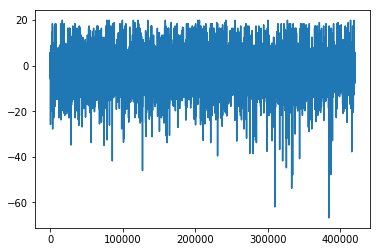

In [135]:
plt.plot(x-true_labels)
#plt.plot(true_labels)


In [18]:
from numpy import mean, sqrt, square, arange
rms = sqrt(mean(square(delta)))
print('Root Mean Squared Error', rms)

Root Mean Squared Error 1.79140886683
